<a href="https://colab.research.google.com/github/hida0/ESAA-2022-2/blob/Practice/Week12_Pr1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Road libraries and Data

In [ ]:
import numpy as np 
import pandas as pd 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/ESAA/data/ratings_Electronics (1).csv', names=['userId', 'productId', 'Rating', 'timestamp'])
data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
data.shape

(7824482, 4)

In [ ]:
data=data.iloc[:1048576, 0:]

In [ ]:
data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [ ]:
data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [ ]:
print("Minimum rating is: %d" %(data.Rating.min()))
print("Maximum rating is: %d" %(data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


### Handling Missing Values

In [ ]:
print("Number of missing values across columns: \n", data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


### EDA: Ratings

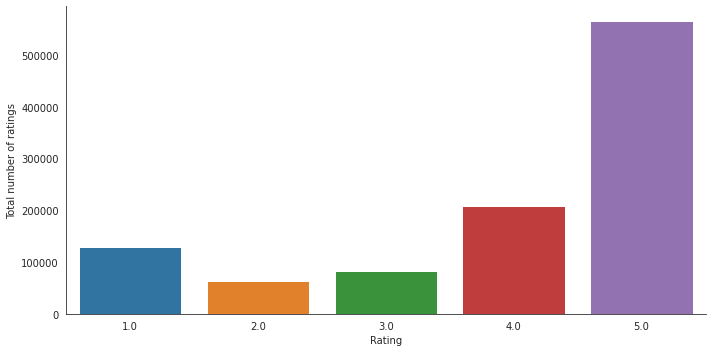

In [ ]:
with sns.axes_style('white'):
    g=sns.factorplot("Rating", data=data, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

### Unique Users and products

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal No of Ratings: ", data.shape[0])
print("Total No of Users: ", len(np.unique(data.userId)))
print("Total No of Products: ", len(np.unique(data.productId)))

Total data 
--------------------------------------------------

Total No of Ratings:  1048576
Total No of Users:  786330
Total No of Products:  61894


In [ ]:
data.drop(['timestamp'], axis=1, inplace=True)

### Analyzing the Rating

In [ ]:
no_of_rated_products_per_user=data.groupby('userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [ ]:
quantiles=no_of_rated_products_per_user.quantile(np.arange(0, 1.01, 0.01), interpolation='higher')
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of rating by user')

Text(0.5, 0, 'Value at the quantile')

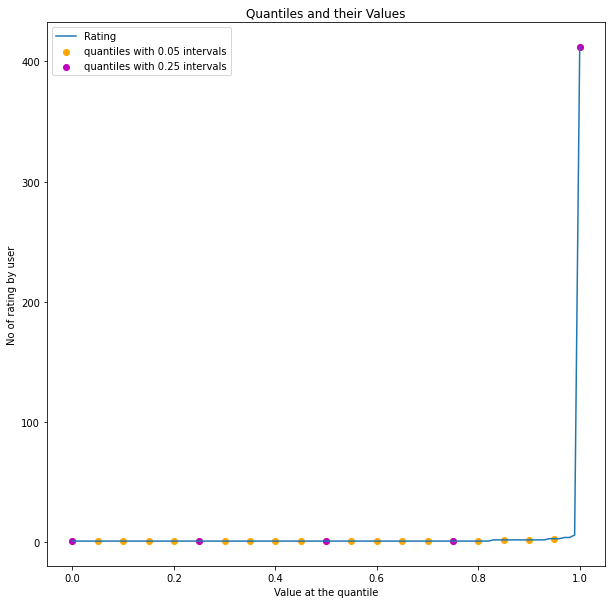

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label='quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label='quantiles with 0.25 intervals')
plt.ylabel("No of rating by user")
plt.xlabel("Value at the quantile")
plt.legend(loc='best')
plt.show()

In [ ]:
print("No of rated product more than 50 per user: {}\n".format(sum(no_of_rated_products_per_user>=50)))

No of rated product more than 50 per user: 38



### Popularity Based Recommendation

In [ ]:
new_df=data.groupby('productId').filter(lambda x:x['Rating'].count()>=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

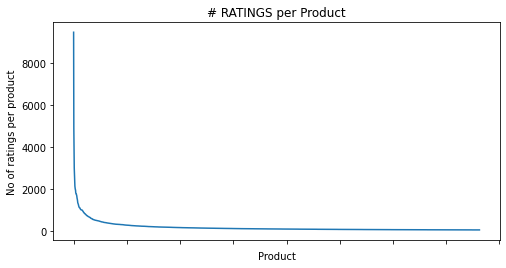

In [ ]:
no_of_ratings_per_product=new_df.groupby('productId')['Rating'].count().sort_values(ascending=False)

fig=plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])
plt.show()

In [ ]:
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [ ]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [ ]:
ratings_mean_count=pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [ ]:
ratings_mean_count['rating_counts']=pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [ ]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [ ]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 576x432 with 0 Axes>

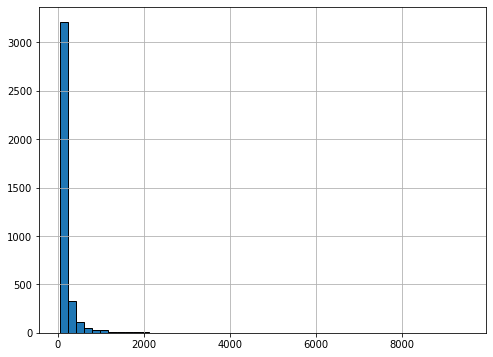

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

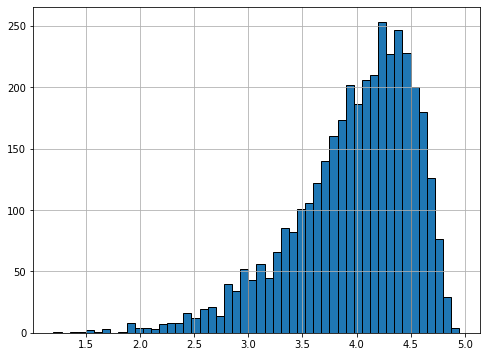

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

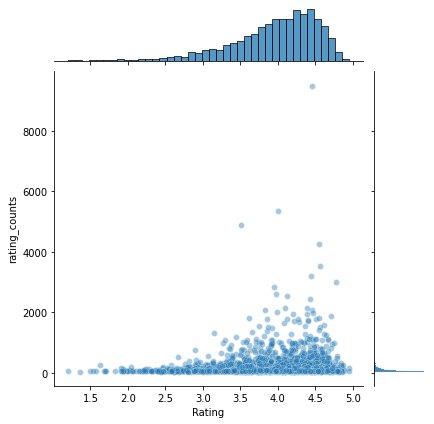

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

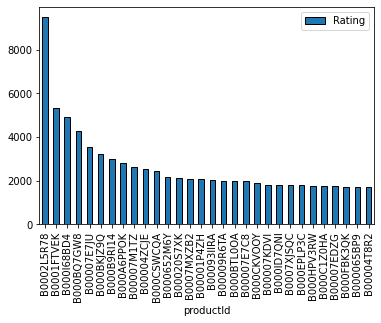

In [ ]:
popular_products=pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular=popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind="bar")

### Collaberative filtering(Item-Item recommendation)

In [ ]:
!pip install surprise

In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
reader=Reader(rating_scale=(1, 5))
data=Dataset.load_from_df(new_df,reader)

In [ ]:
trainset, testset=train_test_split(data, test_size=0.3, random_state=10)

In [ ]:
algo=KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
test_pred=algo.test(testset)
test_pred

In [ ]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

### Model-based collaborative filtering system

In [ ]:
new_df1=new_df.head(10000)
ratings_matrix=new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_matrix.shape

(9832, 76)

In [ ]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(76, 9832)

In [ ]:
X1 = X

In [ ]:
from sklearn.decomposition import TruncatedSVD
SVD=TruncatedSVD(n_components=10)
decomposed_matrix=SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [ ]:
correlation_matrix=np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [ ]:
X.index[75]

'B00000K135'

In [ ]:
i = "B00000K135"

product_names=list(X.index)
product_ID=product_names.index(i)
product_ID

75

In [ ]:
correlation_product_ID=correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [ ]:
Recommend=list(X.index[correlation_product_ID>0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['7214047977',
 '9575871979',
 '9625993428',
 '9983891212',
 '9984984354',
 '9985511476',
 'B000001OM4',
 'B00000J0D5',
 'B00000J0D8',
 'B00000J1EJ',
 'B00000J1EQ',
 'B00000J1SC',
 'B00000J3NF',
 'B00000J4GE',
 'B00000J6WY',
 'B00000JCT8',
 'B00000JCTO',
 'B00000JD34',
 'B00000JYWQ']